# Contribution from ISM phases to the lines' luminosities vs. Mophological and kinematical parameters
In this notebook we will be plotting the morphologycal and kinematical parameters vs. the luminosties from the lines of emission in study, but this time differentiating the IMS phases contributions.   

In [1]:
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import join
from astropy.table import Column
import seaborn as sns

Reading the Mophological and kinematical table

In [2]:
mk = Table.read('../../Data/Q-RefL0100N1504.csv', format = 'ascii')
mk

GalaxyID,DMEllipticity,DiscToTotal,DispAnisotropy,Ellipticity,KappaCoRot,MedOrbitCircu,RotToDispRatio,Triaxiality,GalaxyID_1,ApertureSize,Mass_BH,Mass_DM,Mass_Gas,Mass_Star,VelDisp,SFR,GalID,MasaANegroSubGrid,AcrecionMasaANegro,Masa,MasaMateriaOscura,MasaGas,MasaEstrella,MasaANegro
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
3226889,0.3736355400025354,0.053234520237536054,0.12762756569297418,0.2581218583511655,0.17711417162906362,0.0359092699554268,0.07426425178269415,0.731467244468864,3226889,30,3746210.5,47137317000.0,501801824.0,836548800.0,38.6588,0.055242997,3414,312751.16,3.3191096e-11,135158227000.0,132269515000.0,2034051580.0,850906240.0,3746210.5
5692534,0.3794680042597731,0.5923038422910913,0.15610793754870333,0.5994417898268398,0.43611017551809483,0.5020079041591864,1.1094982352667728,0.6340122442633017,5692534,30,1817607.5,11847346200.0,3186315520.0,402029440.0,28.180422,0.16878024,16957,152797.53,1.1860476e-08,29440280600.0,23684997100.0,5344727000.0,408738368.0,1817607.5
5728920,0.16199965543987083,0.2052219432748401,0.20027541288396222,0.2331522907290403,0.25826545182858085,0.14815552853321978,0.26710337487469393,0.2591651906077923,5728920,30,3630739.8,39546094000.0,86007336.0,954341060.0,42.532383,0.03533982,17211,444080.88,1.4673017e-06,56552276000.0,55504142000.0,86007336.0,958500740.0,3630739.8
10341428,0.22522403443200856,0.20635552541214863,0.13167903604289888,0.2769320448517646,0.2583036216935493,0.10033628913315595,0.24901868995134674,0.03835321337897442,10341428,30,7235433.0,88699978000.0,5952936400.0,3666815740.0,57.195385,0.5762099,2177,1307260.1,0.00045662734,660009320000.0,630488240000.0,25563289600.0,3946914050.0,10851339.0
12566238,0.39665930847987885,0.20231774499123112,0.3824629714473129,0.27186338506935526,0.37057332768210016,0.08536075303010761,0.20290823324391466,0.513724204940099,12566238,30,3615906.0,49454432000.0,207088736.0,813815230.0,47.149002,0.04838007,5300,346079.7,2.3803817e-05,179146932000.0,175577301000.0,2718052100.0,847986430.0,3615906.0
12569982,0.28957023910450475,0.07570525759439017,0.1266082892155065,0.29978039579093707,0.17969222509478536,0.051459490412017334,0.08959003605834988,0.5920203874224141,12569982,30,5574286.0,56434860000.0,314128288.0,546877820.0,39.297363,0.019524526,5311,471089.9,6.538812e-08,180827668000.0,177884692000.0,2371427580.0,565968960.0,5574286.0
12574144,0.2919201561617659,0.491544657813621,0.44694888301122293,0.5635520302420358,0.45334905326890007,0.400614675196549,0.7723461995507785,0.2122303023083452,12574144,30,3616160.5,73711436000.0,582484930.0,2220375810.0,51.5068,0.17847331,5323,765086.1,8.4485544e-07,253882925000.0,247679336000.0,3914793730.0,2283316740.0,5489157.5
12606457,0.3074881813724145,0.0709485417110457,-0.12707574753903073,0.2799876271616091,0.17633480222434897,0.033857167575799874,0.09930474211793842,0.06920872640459172,12606457,30,7245858.5,72771019000.0,622325310.0,2139672580.0,45.1679,0.0764098,5407,854483.75,2.1839597e-08,243127550000.0,236879086000.0,4078521340.0,2162742020.0,7245858.5
12609333,0.3580841248060661,0.09512776790262889,0.04490844649078729,0.1854569078842485,0.17561924751786076,0.07544455318729065,0.12800097449976852,0.7294852707782951,12609333,30,1876768.1,50598445000.0,352582656.0,909681540.0,36.18689,0.096991055,5414,162968.58,3.2437117e-07,150647734000.0,147345310000.0,2376025600.0,924526720.0,1876768.1


Reading the luminosities table

In [3]:
lu = Table.read('../../Data/total_luminosities_frac_RECA.csv', format ='ascii')
lu

GalID,Sim,logLCII,logLNII_205,logLNII_122,logLOI_145,logLOIII_88,logLNIII_57,frac_LdiffCII,frac_LMolCII,frac_LPDRCII,frac_LdiffNII_205,frac_LMolNII_205,frac_LPDRNII_205,frac_LdiffNII_122,frac_LMolNII_122,frac_LPDRNII_122,frac_LdiffOI_145,frac_LMolOI_145,frac_LPDROI_145,frac_LdiffOIII_88,frac_LMolOIII_88,frac_LPDROIII_88,frac_LdiffNIII_57,frac_LMolNIII_57,frac_LPDRNIII_57
float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.0,Ref100,8.450187634229371,7.5256145616261705,7.332794018805233,6.499519055846627,6.394487963631868,5.817649210359375,0.987002716233387,0.00990546392992681,0.0030918198366862728,0.9999963190603157,7.557441594510448e-07,2.925195524831787e-06,0.9999992445660637,4.45207998742248e-07,3.1022593748730607e-07,0.9204456930395319,0.06788592255370686,0.011668384406761073,0.9999999963251491,3.177314120590883e-10,3.357119519306777e-09,0.9999999928222202,1.3904815010627536e-09,5.787298477817435e-09
6.0,Ref100,8.408184353712917,7.495340931392728,7.241338972536405,6.276553499541244,6.476954508915274,5.904120415425211,0.993129758182585,0.0038453358926621804,0.003024905924752824,0.9999951955657519,5.355900374121044e-07,4.268844210711886e-06,0.9999990917477025,2.0789451729536027e-07,7.003577802279861e-07,0.9353641405105333,0.0539674095850742,0.010668449904392549,0.9999999482991668,1.0060185851745217e-10,5.160023123639024e-08,0.9999999353467078,4.987987328872081e-10,6.415449348247119e-08
1.0,Ref100,8.881598281842457,7.998023008500145,7.742776555174997,6.699711844674182,6.9741835146126645,6.4130227940866025,0.9975208660738744,0.0010407897151010898,0.0014383442110245462,0.9999972274864428,5.653714855683894e-07,2.2071420715571637e-06,0.999999277592571,1.0407877286333105e-07,6.183286560590862e-07,0.9619082422615369,0.015794115542636284,0.02229764219582685,0.9999999905769007,3.8277115127510704e-11,9.384822181493024e-09,0.9999999864316408,2.871112628132291e-10,1.3281247888657108e-08
4.0,Ref100,8.486389498348917,7.561499721498752,7.433742679825663,6.794526202400308,6.641563529971638,6.073023254238537,0.990315601994906,0.005257627079043974,0.004426770926050125,0.9999934126296098,2.209235081368387e-06,4.378135308862611e-06,0.9999982433222857,5.678531655450805e-07,1.1888245489283026e-06,0.9425921755656822,0.034648388793777136,0.022759435640540764,0.9999999752269959,2.402017365746171e-10,2.453280225282438e-08,0.9999999648560908,1.929409668022894e-09,3.3214499601911524e-08
7165.0,Ref100,6.421892735076585,4.922430483063327,4.656849446909889,5.101645019101053,4.275201794723876,3.6662452767939766,0.3079069510021695,0.09039407529219488,0.6016989737056356,0.9720436240015272,0.0001324637052989797,0.02782391229317368,0.9727378345077486,1.3659161361965464e-05,0.02724850633088943,0.06431411008764977,0.0012601964056058324,0.9344256935067444,0.9990159348726713,8.362486393089766e-10,0.0009840642910800839,0.998711090682051,3.2947180531718503e-09,0.0012889060232308602
4218.0,Ref100,6.9097527679986435,5.473485157441624,5.225584894137033,4.765516417527379,4.484329531191637,3.869753068480367,0.4038303845228567,0.2156049395886079,0.3805646758885354,0.9932031081586321,0.0002530236253009585,0.006543868216066962,0.9992808444139436,2.8089959747387115e-05,0.0006910656263090253,0.712503883947089,0.1683073026241701,0.1191888134287409,0.9999129919516392,4.800980055861773e-09,8.700324738084174e-05,0.9998826782201313,1.4227416668889722e-08,0.00011730755245203427
114.0,Ref100,7.3128993695140405,6.323854837410285,6.036992571343002,5.708932711355773,5.5350868370202475,4.963773671365811,0.7772563074733413,0.07323965149069062,0.1495040410359679,0.9992312481093698,0.00011911454461894101,0.0006496373460112921,0.9996552480278428,9.248426288283476e-06,0.0003355035458687679,0.14492620537527512,0.2871482921662819,0.567925502458443,0.9999921330744954,1.9279763910256854e-09,7.864997528103974e-06,0.9999901181389423,1.1406166940

Changing the luminosities table to a data frame and removing the data from simulation Recal-L0025N0752

In [4]:
dfl = lu.to_pandas()
indexNames = dfl[ dfl['Sim'] == 'Recal' ].index
dfl.drop(indexNames , inplace=True)

Disregarding data from star mass below 1E9. And calculating the limits to define groups of low, medium and high mass.

In [5]:
dfm = mk.to_pandas()
dfm=dfm.drop(dfm[dfm['Mass_Star']<1E9].index)
dfm['logMStar']=np.log10(dfm['Mass_Star'])
print(dfm['logMStar'].min())
print(dfm['logMStar'].max())
print(dfm['logMStar'].min()+(dfm['logMStar'].max()-dfm['logMStar'].min())/3)
print(dfm['logMStar'].min()+2*(dfm['logMStar'].max()-dfm['logMStar'].min())/3)
print(dfm['logMStar'].min()+3*(dfm['logMStar'].max()-dfm['logMStar'].min())/3)

print(np.percentile(dfm['logMStar'],33), np.percentile(dfm['logMStar'],66))

9.00073191609314
11.651833650344704
9.884432494176995
10.768133072260849
11.651833650344704
9.367971743838858 9.88722593897729


Changing back to astropy table

In [6]:
lu = Table.from_pandas(dfl)
mk = Table.from_pandas(dfm)

Joining the two tables

In [7]:
mk_lu = join(mk,lu,keys='GalID')
mk_lu

GalaxyID,DMEllipticity,DiscToTotal,DispAnisotropy,Ellipticity,KappaCoRot,MedOrbitCircu,RotToDispRatio,Triaxiality,GalaxyID_1,ApertureSize,Mass_BH,Mass_DM,Mass_Gas,Mass_Star,VelDisp,SFR,GalID,MasaANegroSubGrid,AcrecionMasaANegro,Masa,MasaMateriaOscura,MasaGas,MasaEstrella,MasaANegro,logMStar,Sim,logLCII,logLNII_205,logLNII_122,logLOI_145,logLOIII_88,logLNIII_57,frac_LdiffCII,frac_LMolCII,frac_LPDRCII,frac_LdiffNII_205,frac_LMolNII_205,frac_LPDRNII_205,frac_LdiffNII_122,frac_LMolNII_122,frac_LPDRNII_122,frac_LdiffOI_145,frac_LMolOI_145,frac_LPDROI_145,frac_LdiffOIII_88,frac_LMolOIII_88,frac_LPDROIII_88,frac_LdiffNIII_57,frac_LMolNIII_57,frac_LPDRNIII_57
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
21109760,0.2892753387083581,0.01310135781603905,0.2691530802645459,0.47611764490627795,0.1758689272506667,0.005944502800483662,0.010932580574129465,0.9445977410582864,21109760,30,4415859700.0,1483264490000.0,32754356200.0,419670131000.0,301.17545,3.514611,1.0,5192513500.0,0.0003212338,212385529000000.0,179181992000000.0,31954833500000.0,1235139560000.0,13545626600.0,11.622908060458828,Ref100,8.881598281842457,7.998023008500145,7.742776555174997,6.699711844674182,6.9741835146126645,6.4130227940866025,0.9975208660738744,0.0010407897151010898,0.0014383442110245462,0.9999972274864428,5.653714855683894e-07,2.2071420715571637e-06,0.999999277592571,1.0407877286333105e-07,6.183286560590862e-07,0.9619082422615369,0.015794115542636284,0.02229764219582685,0.9999999905769007,3.8277115127510704e-11,9.384822181493024e-09,0.9999999864316408,2.871112628132291e-10,1.3281247888657108e-08
21379521,0.4670360098203262,0.013861639497244838,-0.15781894792666762,0.5843938016118366,0.1623135566375735,0.005165512306726666,0.010969365124098338,0.8448796679260223,21379521,30,10871972.0,1214449980000.0,29204351000.0,353366671000.0,309.48383,6.0781746,2.0,1670997500.0,3.094568e-07,449793436000000.0,377827266000000.0,70041907000000.0,1905425250000.0,18822572000.0,11.548225585115915,Ref100,8.700846335791727,7.822050175262917,7.565280840510923,6.5228917581151755,6.88957319239785,6.322044008183843,0.9899010289995482,0.007203771247424183,0.002895199753027546,0.9999893316430812,5.253457335108229e-06,5.4148995837613804e-06,0.9999984376193387,1.0351425973903641e-06,5.272380639663592e-07,0.840739869267864,0.12981954965062975,0.02944058108150624,0.9999999902754467,3.130961855325246e-10,9.411457154401876e-09,0.9999999852507915,2.4457857578099217e-09,1.2303422944683026e-08
21573586,0.4620505767030071,0.05696273796215212,0.25160837157211813,0.5049790507873873,0.19519494394761505,0.014628751570454446,0.05102430523982849,0.9692825491534175,21573586,30,2011366780.0,759558440000.0,12756882400.0,289014579000.0,278.738,0.85262173,3.0,2733858300.0,0.0007321713,311128471000000.0,263063542000000.0,46387450000000.0,1665041560000.0,12437305300.0,11.460919750782688,Ref100,8.102660710332865,7.176698080884154,7.007512632714062,6.229489886365597,6.256268132523485,5.685925905750241,0.9884998891725243,0.00861589500843816,0.0028842158190375776,0.9999860152656107,6.073034415782391e-06,7.911699973610594e-06,0.9999986167164048,1.0779265011480867e-06,3.053570941593314e-07,0.929625256596918,0.06632765173971567,0.00404709166336631,0.999999994873032,3.779102630202872e-10,4.749057650487573e-09,0.9999999896889928,2.9202479005210993e-09,7.390759192453877e-09
21730535,0.394156678933703,0.006600314137091612,0.33585909363576016,0.5774414722153304,0.17269760342073615,0.003522500902087179,0.005503755137211018,0.9051700043060035,21730535,30,7244372.5,1122822000000.0,21508462600.0,448573538000.0,282.0453,2.198527,4.0,1010320510.0,7.255283e-09,298877412000000.0,2527

Defining two functions

In [8]:
def alpha (E, T):
    return (E**2 + 1 - T )/2

def masa (a,b):
    return a/b

Removing black holes mass bellow cero

In [9]:
mk_lu.remove_row(np.where((mk_lu['Mass_BH'] <= 0))[0][0])

Adding new columns to the table using the functions decribed above and setting the three groups acording to the mass

In [10]:
mk_lu['Alpha']=alpha(mk_lu['Ellipticity'], mk_lu['Triaxiality'])
mk_lu['SFR/SM']=masa(mk_lu['SFR'], mk_lu['Mass_Star'])
mk_lu
mk_lu['logMStar']=np.log10(mk_lu['Mass_Star'])
grupo1=np.logical_and(mk_lu['logMStar']>9, mk_lu['logMStar']<9.36453186705459)
grupo2=np.logical_and(mk_lu['logMStar']>9.36453186705459, mk_lu['logMStar']<10.01875327552434)
grupo3=np.logical_and(mk_lu['logMStar']>10.01875327552434, mk_lu['logMStar']<10.85251655334973)

Creating new columns to the table with the logarithmic values of some data

In [11]:
mk_lu['log(RotToDispRatio)']=np.log10(mk_lu['RotToDispRatio'])
mk_lu['log(SFR/SM)']=np.log10(mk_lu['SFR/SM'])
mk_lu['log(SFR)']=np.log10(mk_lu['SFR'])
mk_lu['log(Mass_BH)']=np.log10(mk_lu['Mass_BH'])

Defining the percentiles and the mean

In [12]:
def per_25(array):
    """Percentile at 16th"""
    return np.nanpercentile(array, 25)

def per_75(array):
    """Percentile at 84th"""
    return np.nanpercentile(array, 75)

In [13]:
param=['VelDisp', 'Alpha', 'log(RotToDispRatio)', 'log(SFR)', 'log(SFR/SM)']
range_par = [(0,200),(0.2,0.8),(-1.5,0.3),(-2,1), (-11.5,-9)]
luparam=['frac_LdiffCII','frac_LMolCII','frac_LPDRCII', 'frac_LdiffOI_145','frac_LMolOI_145',
         'frac_LPDROI_145']

means = [[ 0 for i in range(5) ] for j in range(6)]
edges = [[ 0 for i in range(5) ] for j in range(6)]
per25 = [[ 0 for i in range(5) ] for j in range(6)]
per75 = [[ 0 for i in range(5) ] for j in range(6)]

for j, parm in enumerate(param):
    for i, lparam in enumerate(luparam):
        mean, edge, numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16)
        means[i][j]=mean
        edges[i][j]=edge
        means25, edge ,numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16, statistic=per_25)
        per25[i][j]=means25
        means75, edge, numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16, statistic=per_75)
        per75[i][j]=means75


Graphing parameters vs. parameters

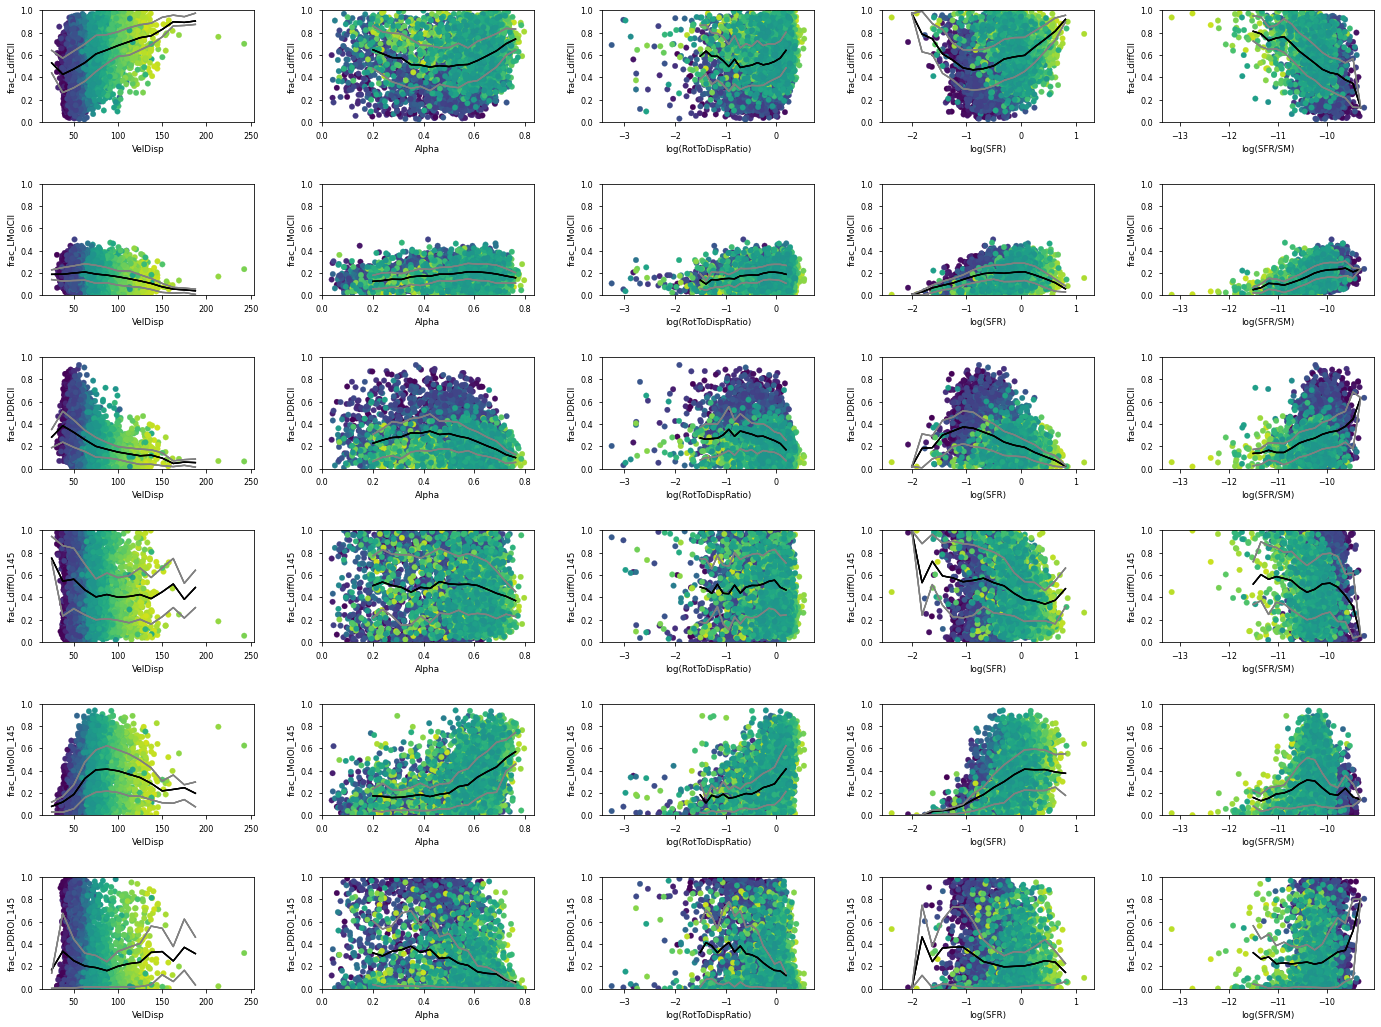

In [14]:
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(6,5,figsize=(20,15), facecolor= 'white')
    fig.tight_layout(pad=4)

    for i_grp, grp in enumerate([grupo1, grupo2, grupo3]):
        for i_lp,lparam in enumerate(luparam):
            for i_m, mparam in enumerate(param): 
                ax[i_lp,i_m].scatter(mk_lu[mparam][grp],mk_lu[lparam][grp],
                                     c=mk_lu['logMStar'][grp], vmin=9, vmax=11, cmap='viridis')
                ax[i_lp,i_m].plot(edges[i_lp][i_m][:-1], means[i_lp][i_m], color='black')
                ax[i_lp,i_m].plot(edges[i_lp][i_m][:-1], per25[i_lp][i_m], color='gray')
                ax[i_lp,i_m].plot(edges[i_lp][i_m][:-1], per75[i_lp][i_m], color='gray')
                ax[i_lp,i_m].set_xlabel(mparam)
                ax[i_lp,i_m].set_ylabel(lparam)
                ax[i_lp,i_m].set_ylim(0,1)


In [15]:
fig.savefig('../Figures/ISMPhases.pdf')
fig.savefig('../Figures/ISMPhases.png')

Choosing the most telling plots and recalculating the corresponding mean

In [16]:
luparam0=['frac_LdiffCII','frac_LPDRCII','frac_LMolOI_145']

means0 = [[ 0 for i in range(5) ] for j in range(3)]
edges0 = [[ 0 for i in range(5) ] for j in range(3)]
per250 = [[ 0 for i in range(5) ] for j in range(3)]
per750 = [[ 0 for i in range(5) ] for j in range(3)]

for j, parm in enumerate(param):
    for i, lparam in enumerate(luparam0):
        mean, edge, numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16)
        means0[i][j]=mean
        edges0[i][j]=edge
        means25, edge ,numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16, statistic=per_25)
        per250[i][j]=means25
        means75, edge, numbers = stats.binned_statistic(mk_lu[parm], mk_lu[lparam], range=range_par[j], bins=16, statistic=per_75)
        per750[i][j]=means75


Setting figure style for presentation

In [17]:
sns.set()
sns.set_style("white")
sns.set_context("talk")

Plotting the chosen parameters 

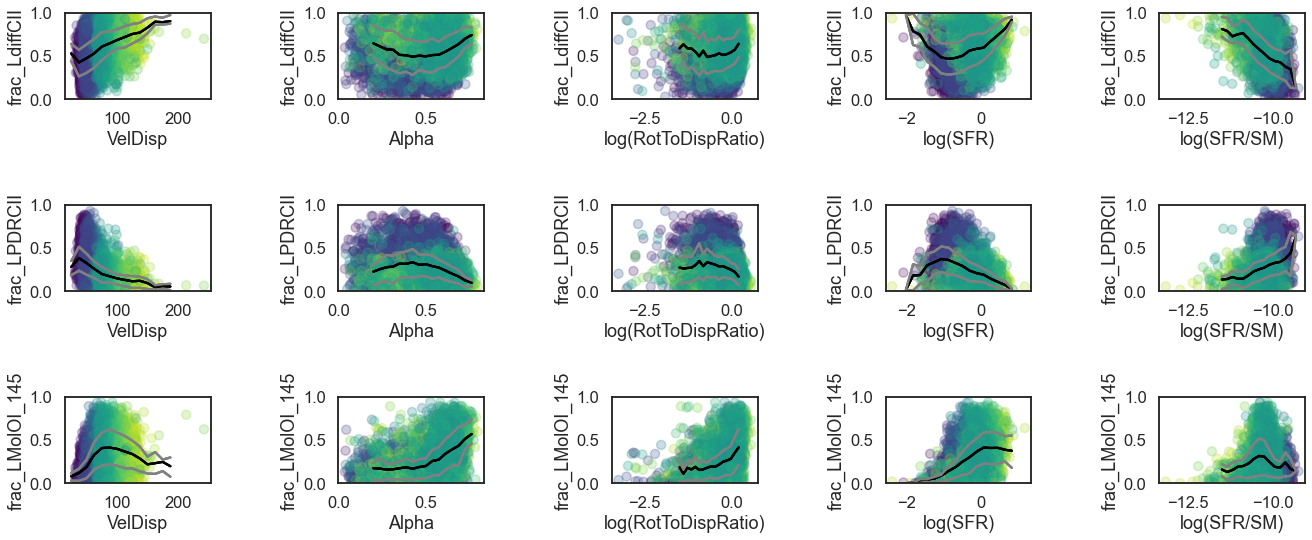

In [18]:
fig, ax = plt.subplots(3,5,figsize=(20,9), facecolor= 'white')
fig.tight_layout(pad=4)

for i_grp, grp in enumerate([grupo1, grupo2, grupo3]):
    for i_lp,lparam in enumerate(luparam0):
        for i_m, mparam in enumerate(param): 
#       ax[i_m,i_lp].scatter(mk_lu[mparam][grp],mk_lu[lparam][grp],color=cparam, marker=markers[i_grp])
            ax[i_lp,i_m].scatter(mk_lu[mparam][grp],mk_lu[lparam][grp],
                                 c=mk_lu['logMStar'][grp], vmin=9, vmax=11, cmap='viridis', alpha=0.25)
            ax[i_lp,i_m].plot(edges0[i_lp][i_m][:-1], means0[i_lp][i_m], color='black')
            ax[i_lp,i_m].plot(edges0[i_lp][i_m][:-1], per250[i_lp][i_m], color='gray')
            ax[i_lp,i_m].plot(edges0[i_lp][i_m][:-1], per750[i_lp][i_m], color='gray')
            ax[i_lp,i_m].set_xlabel(mparam)
            ax[i_lp,i_m].set_ylabel(lparam)
            ax[i_lp,i_m].set_ylim(0,1)


In [19]:
fig.savefig('../Figures/ISMPhasesPresentation.pdf')
fig.savefig('../Figures/ISMPhasesPresentation.png')